In [1]:
from data_loader import load_data
from plot_utils import show_transform_plot
from functools import partial
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import ticker

In [2]:
train = load_data()

In [3]:
col_dtypes = train.dtypes
num_feats = col_dtypes[col_dtypes != 'object'].axes[0].tolist()
cat_feats = col_dtypes[col_dtypes == 'object'].axes[0].tolist()

In [4]:
#create variables for convenience
cat = train[cat_feats]
price = train['SalePrice']
print(cat.columns)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


# Categorical Features analysis

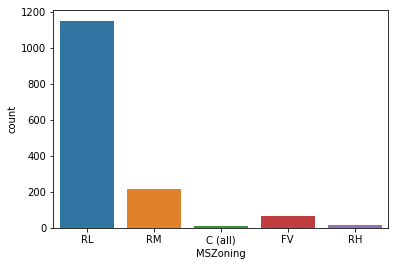

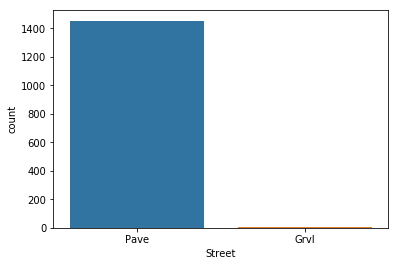

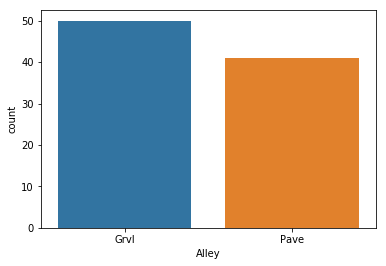

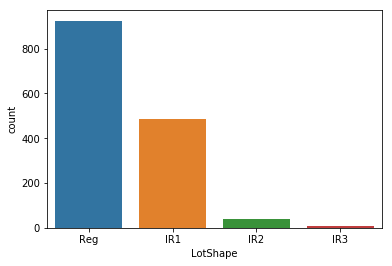

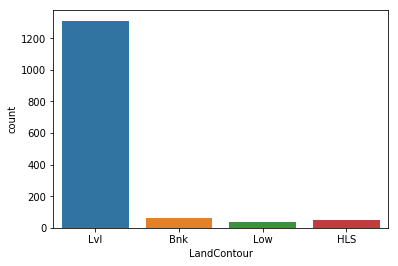

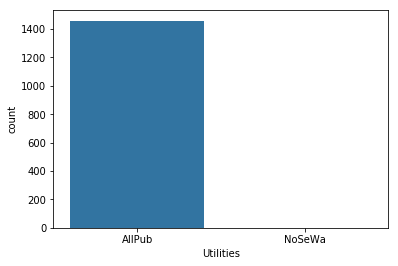

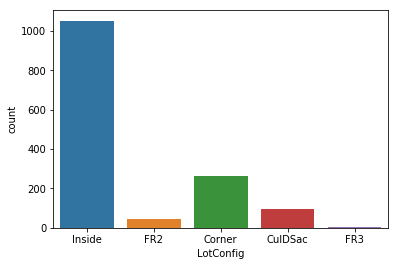

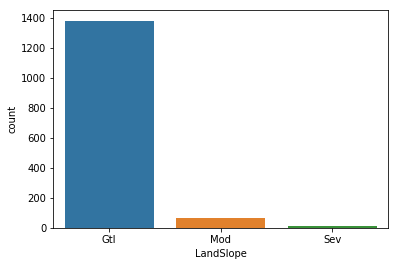

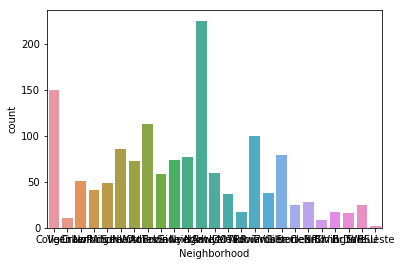

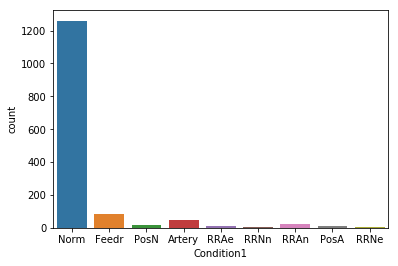

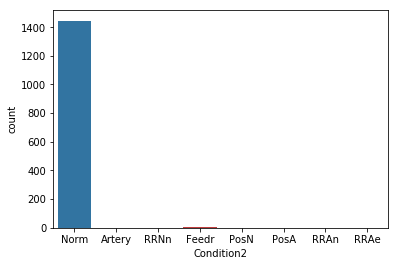

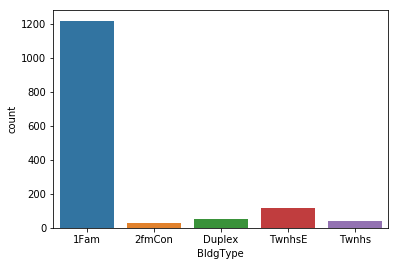

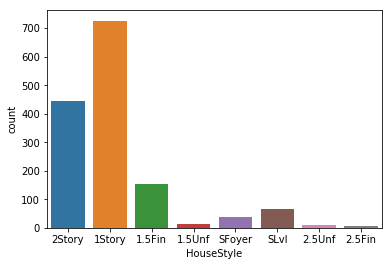

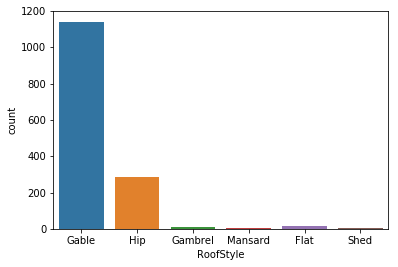

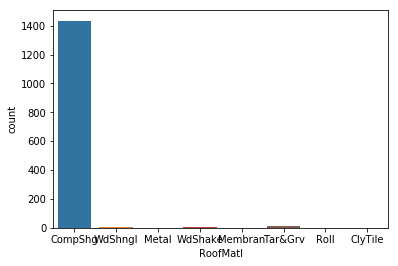

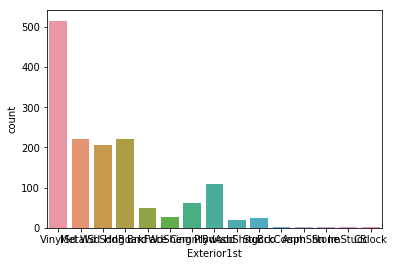

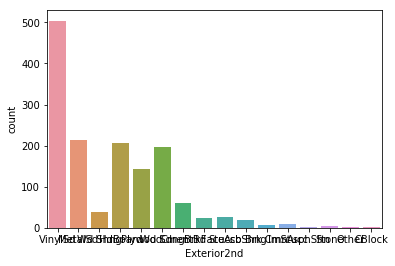

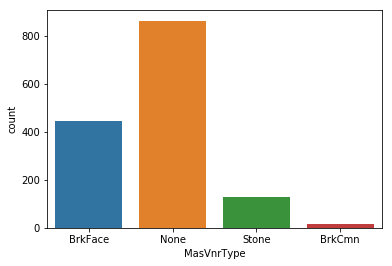

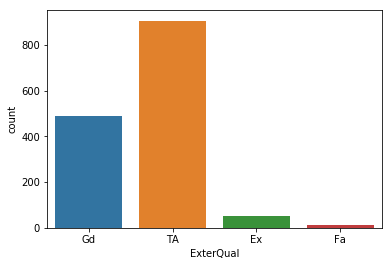

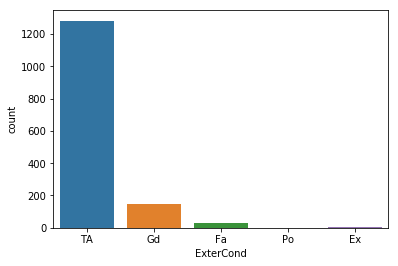

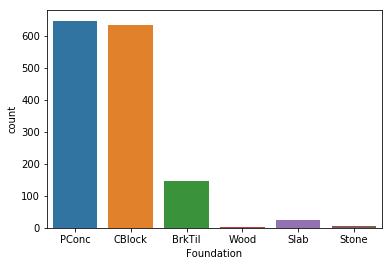

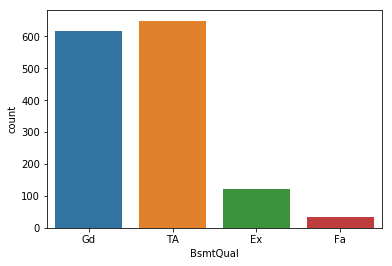

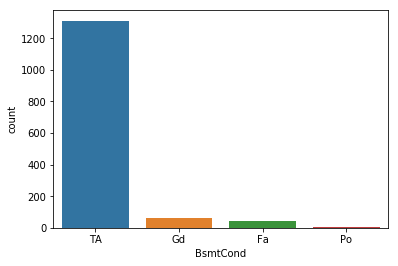

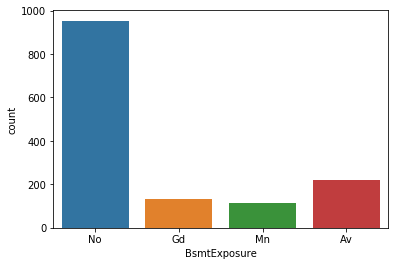

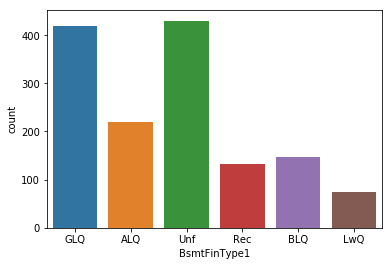

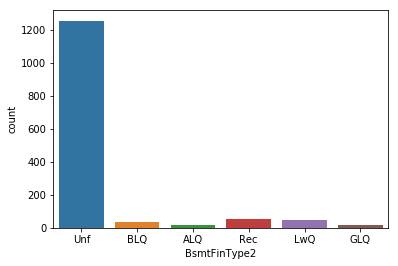

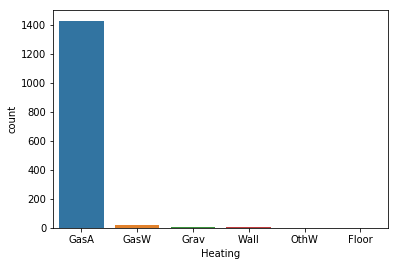

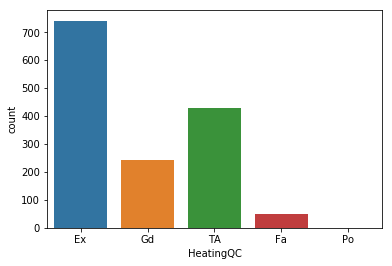

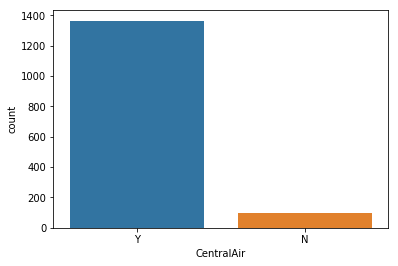

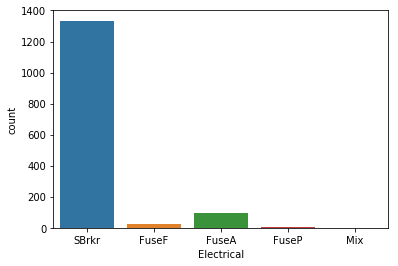

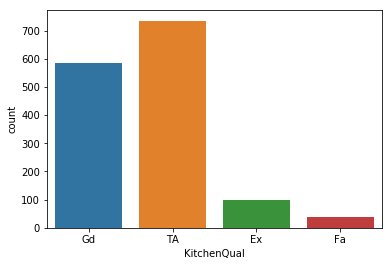

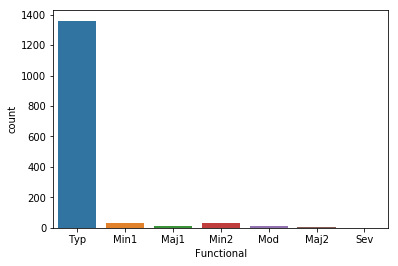

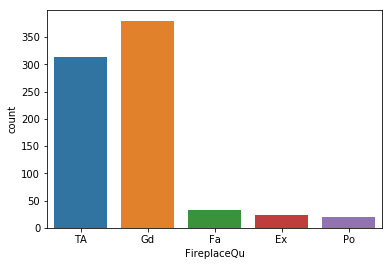

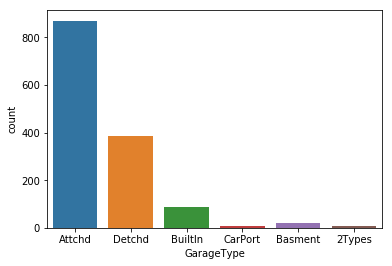

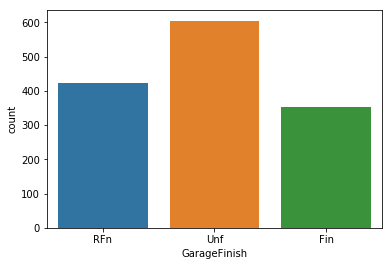

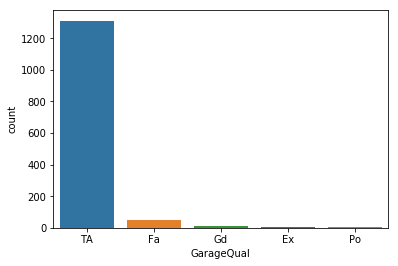

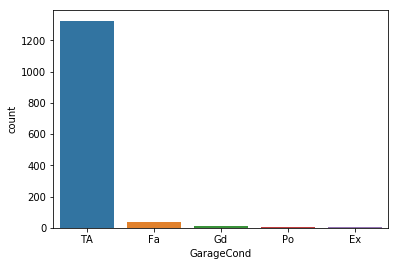

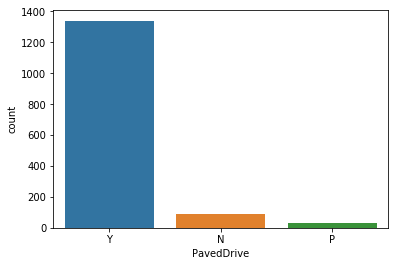

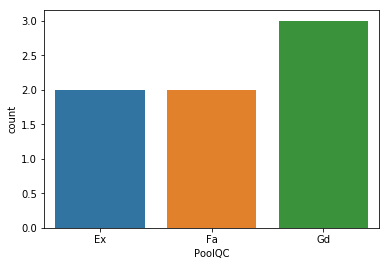

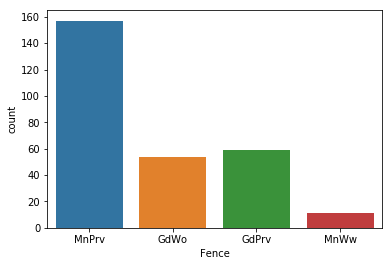

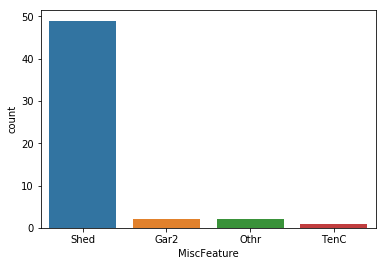

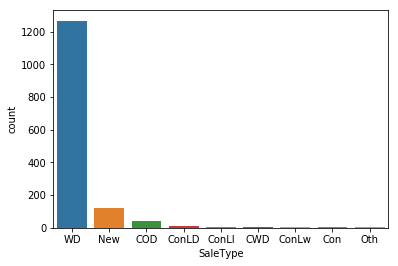

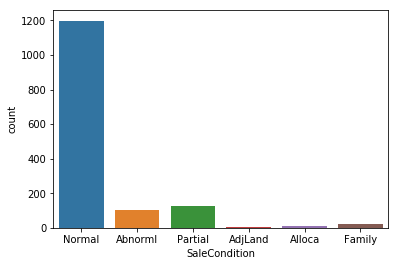

In [5]:
for feat in cat_feats:
    sns.countplot(cat[feat])
    plt.show()

- group all IRx LotShape into one category
- group LandContour (Bnk, Low, HLS) into one category
- drop Utilities - only one different example
- LotCinfig (FR2, FR3) group together
- drop Condition2, since almost all are Norm
- group some HouseStyle feats (mayber finished and unfinished together)
- group RoofStyle, RoofMatl, Exterior1st, Exterior2nd, Foundation
- rare conditions to two groups: good/bad
- group heating two gases into one
- group GarageType, SaleType

## Neighborhood

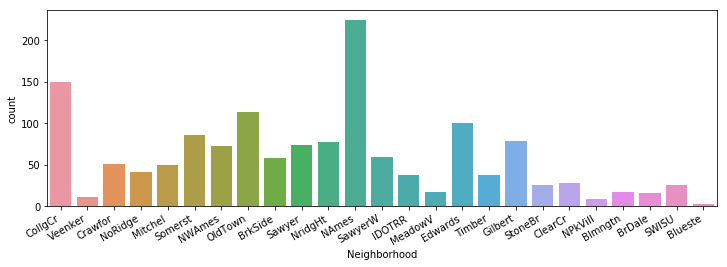

In [6]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(cat['Neighborhood'], ax=ax)
fig.autofmt_xdate()

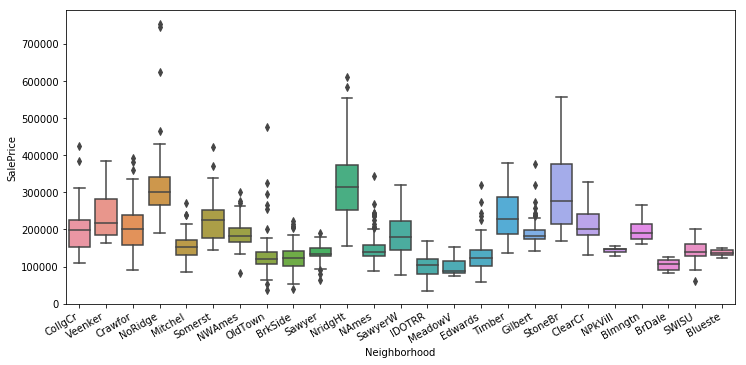

In [7]:
neighborhood_as_cat = cat['Neighborhood'].astype('category')
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(cat['Neighborhood'], price, ax=ax)
fig.autofmt_xdate()

In [8]:
cat['Neighborhood'].value_counts().sort_values()

Blueste      2
NPkVill      9
Veenker     11
BrDale      16
MeadowV     17
Blmngtn     17
SWISU       25
StoneBr     25
ClearCr     28
IDOTRR      37
Timber      38
NoRidge     41
Mitchel     49
Crawfor     51
BrkSide     58
SawyerW     59
NWAmes      73
Sawyer      74
NridgHt     77
Gilbert     79
Somerst     86
Edwards    100
OldTown    113
CollgCr    150
NAmes      225
Name: Neighborhood, dtype: int64

1. Reduce neighborhood values: for purpose of dimensionality reduction we can group together some similar (with respect to price correlation) neighborhoods into one and create ordinal variable describes neighborhood atractiveness (classify to mode category when hasn't been seen yet)
    - division due to qcut is reasonable

In [9]:
grouped_neigh = train.groupby('Neighborhood')

In [10]:
neigh_LandSlope = grouped_neigh['LandSlope'].value_counts()
neigh_LandContour = grouped_neigh['LandContour'].value_counts()
neigh_MSZoning = grouped_neigh['MSZoning'].value_counts()

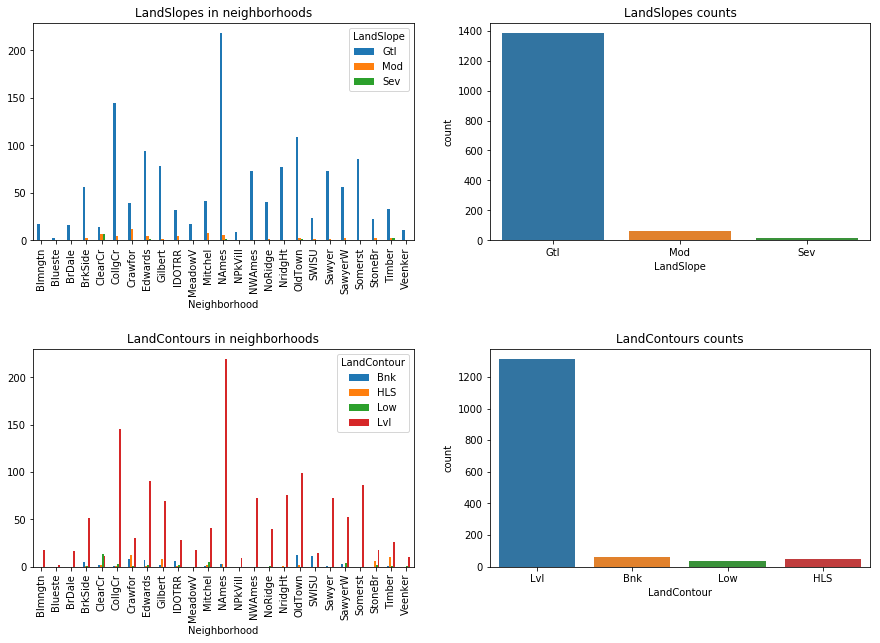

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
neigh_LandSlope.unstack(level=1).plot(kind='bar', ax=ax[0,0])
ax[0,0].set_title('LandSlopes in neighborhoods')
sns.countplot(cat['LandSlope'], ax=ax[0,1])
ax[0,1].set_title("LandSlopes counts")
neigh_LandContour.unstack(level=1).plot(kind='bar', ax = ax[1,0])
ax[1,0].set_title("LandContours in neighborhoods")
sns.countplot(cat['LandContour'], ax=ax[1,1])
ax[1,1].set_title('LandContours counts')
plt.subplots_adjust(hspace=.5)

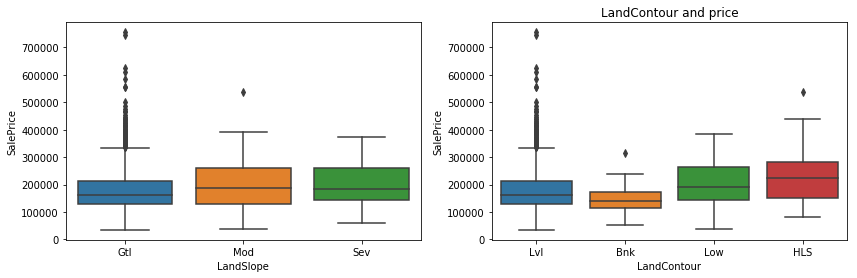

In [12]:
_, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.boxplot(cat['LandSlope'], price, ax=ax[0])
plt.title('LandSlope and price')
sns.boxplot(cat['LandContour'], price, ax=ax[1])
plt.title('LandContour and price')
plt.show()

1. Most of the time LandSlope is Gtl. There is small number of neighborhoods where LandSlope other than Gtl is noticable. However such landslopes are more expensive than with Gtl
- LandContour beahves similar to LandSlope: most of values are set Lvl and there are several Neighbourhoods where other LandContour's values are noticable and there are significant differences in price between each value
- Neighborhood hasn't any significant impact on LandSlope or LandContour

## SaleCondition

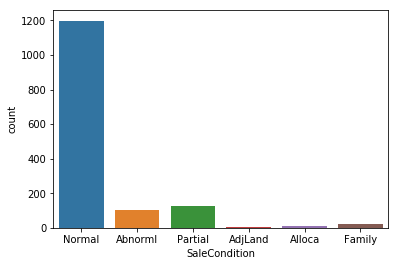

In [13]:
sns.countplot(cat['SaleCondition'])

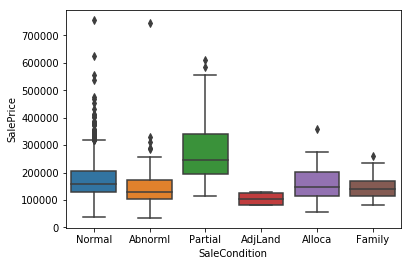

In [14]:
sns.boxplot(cat['SaleCondition'], price)

In [15]:
grouped_SaleCond = train.groupby('SaleCondition')

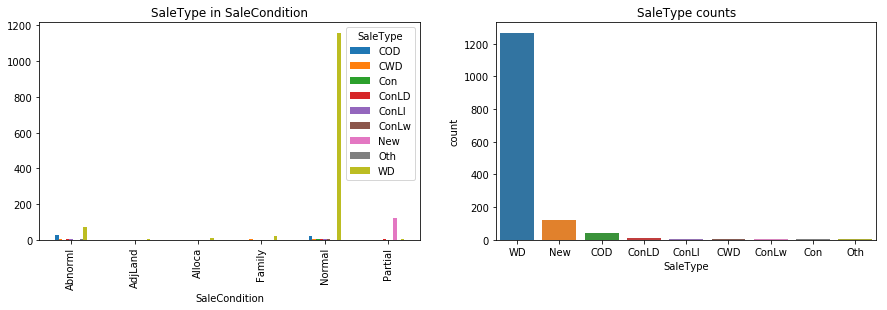

In [16]:
_, ax = plt.subplots(1,2, figsize=(15,4))
grouped_SaleCond['SaleType'].value_counts().unstack(level=1).plot(kind='bar', ax=ax[0])
sns.countplot(cat['SaleType'], ax=ax[1])
ax[0].set_title('SaleType in SaleCondition')
ax[1].set_title('SaleType counts')
plt.show()

1. Most of SaleCondition are normal, however any other significant values are: Abnorml ot Partial. Other values aren't noticable
- Alloca, Family and Abnrml are similar to the normal so we can join them toghether (escpecially that Normal has big variance and except Abnorml these features are represent by not too many datapoints)
- Normal SaleCondition is mostly WD (warranty-dead) and, which is quite reasonable, Partial has most of values set to New
- MiscFeature with valu=Shed are mostly in Normal (where other values are rare), however Alloca and Abnorml are only Shed (and in small number of datapoints). At all MiscFeatures are very rare because of missing values (saying that are no misc features)

## Pool features

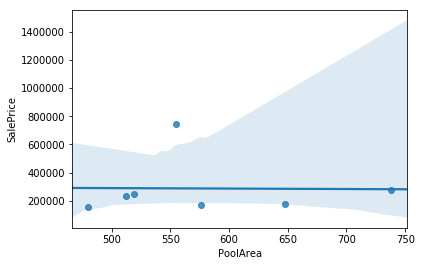

In [17]:
nonzero_pool = train['PoolArea']>0
sns.regplot(train[nonzero_pool]['PoolArea'], price[nonzero_pool])

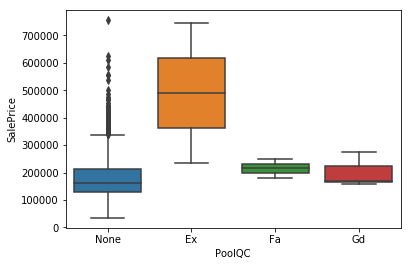

In [18]:
sns.boxplot(cat['PoolQC'].fillna("None"), price)

1. Most of houses haven't any pool, hence their PoolArea is set to 0 and PoolQC to NaN. **There is only 7 houses with pools**
- When there is Pool in the house, its area isn't correlated with SalePrice and some datapoints are (weakly) correlated with LotFrontage (since bigger lot is needed for pool), so it hasn't any influence on price
    - taking advantage of this observation we could apply indicator to determine if pool exists
    - If there is so small number of houses with pools and their areas aren't correlated with price we can delete this feature
- PoolQC laid in almost same price intervals for each value, only Ex quality in much higher, however there is only two houses with excellent pool quality
    - PoolQC seems to not add much information, so we could try to delete this feature

## LotShape

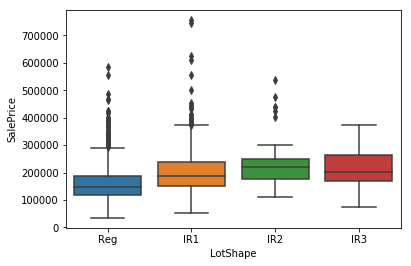

In [19]:
sns.boxplot(train['LotShape'], price)

1. There are 4 kinds of lot shape, one is regular which is spread over all SalePrice values (almost all), and rest irregular kind are similar in SalePrice, however their variance is different.

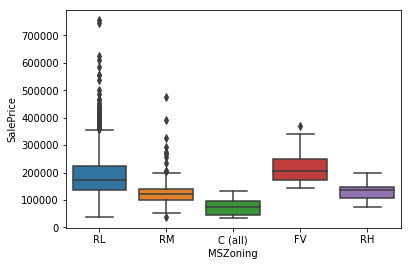

In [20]:
sns.boxplot(train['MSZoning'], price)

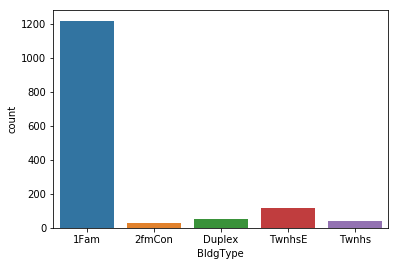

In [33]:
sns.countplot(train['BldgType'])